In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [2]:
seed = 42
random.set_seed(seed)
np.random.seed(seed)


In [3]:
styles_path = '../styles.csv'

df = pd.read_csv(styles_path, on_bad_lines='skip')

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
category_counts = df['articleType'].value_counts()

pd.set_option('display.max_rows', None) 
print(category_counts)

articleType
Tshirts                      7067
Shirts                       3217
Casual Shoes                 2845
Watches                      2542
Sports Shoes                 2036
Kurtas                       1844
Tops                         1762
Handbags                     1759
Heels                        1323
Sunglasses                   1073
Wallets                       936
Flip Flops                    914
Sandals                       897
Briefs                        849
Belts                         813
Backpacks                     724
Socks                         686
Formal Shoes                  637
Perfume and Body Mist         613
Jeans                         609
Shorts                        547
Trousers                      530
Flats                         500
Bra                           477
Dresses                       464
Sarees                        427
Earrings                      416
Deodorant                     347
Nail Polish                   329
Li

In [5]:
# WARIANTY KLAS GENDER
variant = 2  # Zmień na 1, 2, 3 lub 4

if variant == 1:
    # Wariant 1: tylko Woman i Man
    df = df[df['gender'].isin(['Men', 'Women'])]

elif variant == 2:
    # Wariant 2: Woman, Man, Kids (boys, girls), Unisex
    def map_gender(g):
        if g in ['Boys', 'Girls']:
            return 'Kids'
        return g
    df['gender'] = df['gender'].apply(map_gender)
    df = df[df['gender'].isin(['Men', 'Women', 'Kids', 'Unisex'])]

elif variant == 3:
    # Wariant 3: Woman, Man, Other (boys, girls, unisex)
    def map_gender(g):
        if g in ['Boys', 'Girls', 'Unisex']:
            return 'Other'
        return g
    df['gender'] = df['gender'].apply(map_gender)
    df = df[df['gender'].isin(['Men', 'Women', 'Other'])]

elif variant == 4:
    # Wariant 4: Woman, Man, Unisex
    df = df[df['gender'].isin(['Men', 'Women', 'Unisex'])]

# Sprawdź nowe klasy
gender_counts = df['gender'].value_counts()

pd.set_option('display.max_rows', None) 
print("Zmapowane klasy gender:")
print(gender_counts)


Zmapowane klasy gender:
gender
Men       22147
Women     18631
Unisex     2161
Kids       1485
Name: count, dtype: int64


In [6]:
# ucinamy zbiór na 416 (zaleca sie 500)

In [7]:
df.isnull().sum()


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [8]:
df.isnull().sum()
df.dropna(inplace=True)

In [9]:
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [10]:
images_path = '../images/'

df['image_path'] = df['id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)].copy() 

In [11]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../images/59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../images/21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../images/53759.jpg


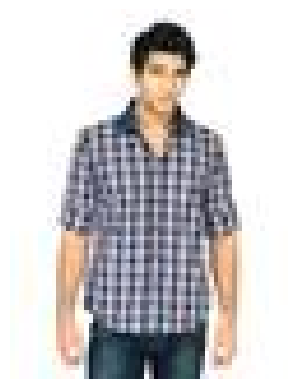

In [12]:
first_image_path = df['image_path'].iloc[0]

image = Image.open(first_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
category_counts = df['articleType'].value_counts()

min_count = 400

# filtered_categories = category_counts[category_counts >= min_count].index
filtered_categories = category_counts[category_counts > min_count].index

df = df[df['articleType'].isin(filtered_categories)]

category_counts = df['articleType'].value_counts()

for category, count in category_counts.items():
    print(f"{category}: {count}")

Tshirts: 7065
Shirts: 3212
Casual Shoes: 2845
Watches: 2542
Sports Shoes: 2016
Kurtas: 1844
Tops: 1762
Handbags: 1759
Heels: 1323
Sunglasses: 1073
Wallets: 928
Flip Flops: 914
Sandals: 895
Briefs: 847
Belts: 813
Backpacks: 724
Socks: 686
Formal Shoes: 637
Perfume and Body Mist: 603
Jeans: 602
Shorts: 547
Trousers: 530
Flats: 500
Bra: 477
Dresses: 464
Sarees: 427
Earrings: 416


In [14]:
df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [15]:
df.to_csv('../backend/dataframe.csv', index=False)

In [16]:
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../images/59263.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../images/53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,../images/1855.jpg


In [17]:
# preprocessing obrazków:

# def preprocess_image(image_path, target_size=(128, 128)):
#     img = load_img(image_path, target_size=target_size)
#     img_array = img_to_array(img) / 255.0  # Normalizacja
#     return img_array


In [18]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

image_arrays = []
valid_indices = []

for idx, path in enumerate(df["image_path"]):
    img_array = preprocess_image(path)
    if img_array is not None:
        image_arrays.append(img_array)
        valid_indices.append(idx)

# Przefiltruj DataFrame by odpowiadał poprawnym obrazom
df_clean = df.iloc[valid_indices].reset_index(drop=True)
images = np.array(image_arrays)

In [19]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [20]:
gender_encoder = LabelEncoder()
article_encoder = LabelEncoder()

df_clean["gender_encoded"] = gender_encoder.fit_transform(df_clean["gender"])
df_clean["article_encoded"] = article_encoder.fit_transform(df_clean["articleType"])

y_gender = df_clean["gender_encoded"].values
y_article = df_clean["article_encoded"].values

In [21]:
X_train, X_val, y_gender_train, y_gender_val, y_article_train, y_article_val = train_test_split(images, y_gender, y_article, test_size=0.2, random_state=42)

In [22]:
input_tensor = Input(shape=(128, 128, 3))

# MobileNetV2 z wagami ImageNet, bez górnych warstw
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False  # zamrożenie wag

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Wyjście 1: gender (multi-class)
gender_output = Dense(len(gender_encoder.classes_), activation="softmax", name="gender")(x)

# Wyjście 2: articleType (multi-class)
article_output = Dense(len(article_encoder.classes_), activation="softmax", name="article")(x)

# Model
model = Model(inputs=input_tensor, outputs=[gender_output, article_output])

/var/folders/7g/d8ckv1rx1kb58dsmtxs162780000gn/T/ipykernel_29334/1534803227.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        "gender": "sparse_categorical_crossentropy",
        "article": "sparse_categorical_crossentropy"
    },
    metrics={
        "gender": "accuracy",
        "article": "accuracy"
    }
)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {"gender": y_gender_train, "article": y_article_train},
    validation_data=(X_val, {"gender": y_gender_val, "article": y_article_val}),
    epochs=10,
    batch_size=32
)

Epoch 1/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - article_accuracy: 0.3583 - article_loss: 2.2784 - gender_accuracy: 0.6561 - gender_loss: 0.8582 - loss: 3.1366 - val_article_accuracy: 0.7603 - val_article_loss: 0.8647 - val_gender_accuracy: 0.8436 - val_gender_loss: 0.4360 - val_loss: 1.3008
Epoch 2/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 73s 80ms/step - article_accuracy: 0.6766 - article_loss: 1.0869 - gender_accuracy: 0.7967 - gender_loss: 0.5662 - loss: 1.6531 - val_article_accuracy: 0.8232 - val_article_loss: 0.6087 - val_gender_accuracy: 0.8656 - val_gender_loss: 0.3801 - val_loss: 0.9889
Epoch 3/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 127s 139ms/step - article_accuracy: 0.7508 - article_loss: 0.8243 - gender_accuracy: 0.8277 - gender_loss: 0.4937 - loss: 1.3180 - val_article_accuracy: 0.8438 - val_article_loss: 0.5058 - val_gender_accuracy: 0.8724 - val_gender_loss: 0.3610 - val_loss: 0.8669
Epoch 4/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 107s 117ms/step - article_accuracy: 0.7902 - article_loss:

In [25]:
history.history

{'article_accuracy': [0.5010973811149597,
  0.699416995048523,
  0.7583675980567932,
  0.795198917388916,
  0.8150205612182617,
  0.8284636735916138,
  0.8393347263336182,
  0.8522633910179138,
  0.8597050905227661,
  0.8657407164573669],
 'article_loss': [1.7487486600875854,
  1.0119682550430298,
  0.7942036390304565,
  0.6687920093536377,
  0.5963964462280273,
  0.5421302914619446,
  0.5004821419715881,
  0.4617065489292145,
  0.43002083897590637,
  0.4034729599952698],
 'gender_accuracy': [0.7144032716751099,
  0.8024691343307495,
  0.8288751840591431,
  0.8444444537162781,
  0.855967104434967,
  0.8653292059898376,
  0.8738340139389038,
  0.8813443183898926,
  0.8871741890907288,
  0.8941701054573059],
 'gender_loss': [0.7438749074935913,
  0.5521767139434814,
  0.4857724606990814,
  0.44136789441108704,
  0.40688443183898926,
  0.37975889444351196,
  0.3577076494693756,
  0.33677926659584045,
  0.31812405586242676,
  0.30436402559280396],
 'loss': [2.493469476699829,
  1.564622282

In [26]:
print('last validation loss:', history.history['loss'][-1])
print('last validation loss:', history.history['val_loss'][-1])

last validation loss: 0.7083408832550049
last validation loss: 0.6492233872413635


In [27]:
# Całkowita strata
fig_loss_total = go.Figure()
fig_loss_total.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig_loss_total.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Val Loss'))
fig_loss_total.update_layout(title='Total Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss_total.show()

# Strata per output
fig_loss_outputs = go.Figure()
fig_loss_outputs.add_trace(go.Scatter(y=history.history['gender_loss'], mode='lines', name='Train Gender Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['val_gender_loss'], mode='lines', name='Val Gender Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['article_loss'], mode='lines', name='Train Article Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['val_article_loss'], mode='lines', name='Val Article Loss'))
fig_loss_outputs.update_layout(title='Loss per Output', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss_outputs.show()

# ACC per output
fig_acc = go.Figure()

fig_acc.add_trace(go.Scatter(y=history.history['gender_accuracy'], mode='lines', name='Train Gender Accuracy'))
fig_acc.add_trace(go.Scatter(y=history.history['val_gender_accuracy'], mode='lines', name='Val Gender Accuracy'))

fig_acc.add_trace(go.Scatter(y=history.history['article_accuracy'], mode='lines', name='Train Article Accuracy'))
fig_acc.add_trace(go.Scatter(y=history.history['val_article_accuracy'], mode='lines', name='Val Article Accuracy'))

fig_acc.update_layout(title='Accuracy per Output', xaxis_title='Epoch', yaxis_title='Accuracy')
fig_acc.show()

In [28]:
results = model.evaluate(X_val, {"gender": y_gender_val, "article": y_article_val})
print("Wyniki walidacji:", results)

228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - article_accuracy: 0.8784 - article_loss: 0.3607 - gender_accuracy: 0.8925 - gender_loss: 0.3100 - loss: 0.6708
Wyniki walidacji: [0.6492233872413635, 0.3050878345966339, 0.34403032064437866, 0.8843780159950256, 0.8912357687950134]


In [29]:
y_pred_gender, y_pred_article = model.predict(X_val)

y_pred_gender_classes = np.argmax(y_pred_gender, axis=1)
y_pred_article_classes = np.argmax(y_pred_article, axis=1)

print(classification_report(
    y_gender_val,
    y_pred_gender_classes,
    target_names=gender_encoder.classes_
))

print(classification_report(
    y_article_val,
    y_pred_article_classes,
    target_names=article_encoder.classes_
))

228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step
              precision    recall  f1-score   support

        Kids       0.83      0.68      0.75       265
         Men       0.89      0.95      0.92      3884
      Unisex       0.76      0.40      0.53       357
       Women       0.91      0.89      0.90      2785

    accuracy                           0.89      7291
   macro avg       0.85      0.73      0.77      7291
weighted avg       0.89      0.89      0.89      7291

                       precision    recall  f1-score   support

            Backpacks       0.97      0.95      0.96       158
                Belts       1.00      0.98      0.99       162
                  Bra       0.97      1.00      0.99       101
               Briefs       0.98      0.98      0.98       188
         Casual Shoes       0.72      0.86      0.78       585
              Dresses       0.83      0.33      0.47        89
             Earrings       0.90      0.98      0.94        89
                F

In [30]:
# Mapowanie labeli do nazwa ArticleType
#labels = df['label'].values 
#label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
#print(label_mapping)

In [31]:
df['label'] = df['articleType'].astype('category').cat.codes
label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
print(label_mapping)

label_mapping_gender = dict(enumerate(df['gender'].astype('category').cat.categories))
print(label_mapping_gender)

{0: 'Backpacks', 1: 'Belts', 2: 'Bra', 3: 'Briefs', 4: 'Casual Shoes', 5: 'Dresses', 6: 'Earrings', 7: 'Flats', 8: 'Flip Flops', 9: 'Formal Shoes', 10: 'Handbags', 11: 'Heels', 12: 'Jeans', 13: 'Kurtas', 14: 'Perfume and Body Mist', 15: 'Sandals', 16: 'Sarees', 17: 'Shirts', 18: 'Shorts', 19: 'Socks', 20: 'Sports Shoes', 21: 'Sunglasses', 22: 'Tops', 23: 'Trousers', 24: 'Tshirts', 25: 'Wallets', 26: 'Watches'}
{0: 'Kids', 1: 'Men', 2: 'Unisex', 3: 'Women'}


In [32]:
image_path = os.path.join(images_path, '2208.jpg')

image_array = preprocess_image(image_path, target_size=(128, 128))
image_array = np.expand_dims(image_array, axis=0)  # (1, 128, 128, 3)

pred_gender, pred_article = model.predict(image_array)

pred_gender_class = np.argmax(pred_gender, axis=1)[0]
pred_article_class = np.argmax(pred_article, axis=1)[0]

pred_gender_label = gender_encoder.inverse_transform([pred_gender_class])[0]
pred_article_label = article_encoder.inverse_transform([pred_article_class])[0]

print(f"Predykcja dla obrazu {image_path}:")
print(f"Gender: {pred_gender_label} (klasa {pred_gender_class})")
print(f"Article Type: {pred_article_label} (klasa {pred_article_class})")
print(pred_gender)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predykcja dla obrazu ../images/2208.jpg:
Gender: Men (klasa 1)
Article Type: Casual Shoes (klasa 4)
[[0.00853699 0.8345598  0.04824362 0.10865952]]


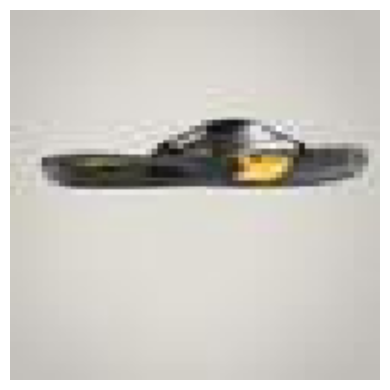

In [33]:
plt.figure(figsize=(4, 4))
img_display = load_img(image_path, target_size=(128, 128))
plt.imshow(img_display)
plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
print("y_article_val shape:", y_article_val.shape)
print("y_pred_article_classes shape:", y_pred_article_classes.shape)

print("Unikalne etykiety y_article_val:", np.unique(y_article_val))
print("Unikalne etykiety y_pred_article_classes:", np.unique(y_pred_article_classes))


y_article_val shape: (7291,)
y_pred_article_classes shape: (7291,)
Unikalne etykiety y_article_val: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Unikalne etykiety y_pred_article_classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


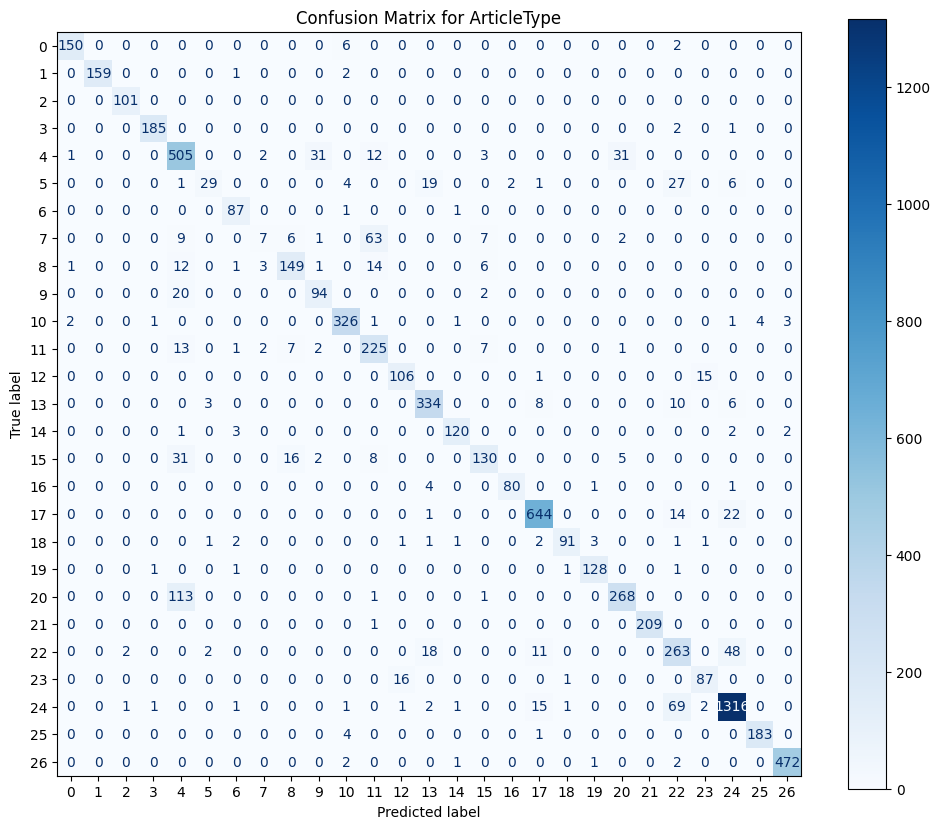

In [35]:
y_pred_article_classes = np.argmax(y_pred_article, axis=1)

cm = confusion_matrix(y_article_val, y_pred_article_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=article_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(12, 10)
plt.title('Confusion Matrix for ArticleType')
plt.show()

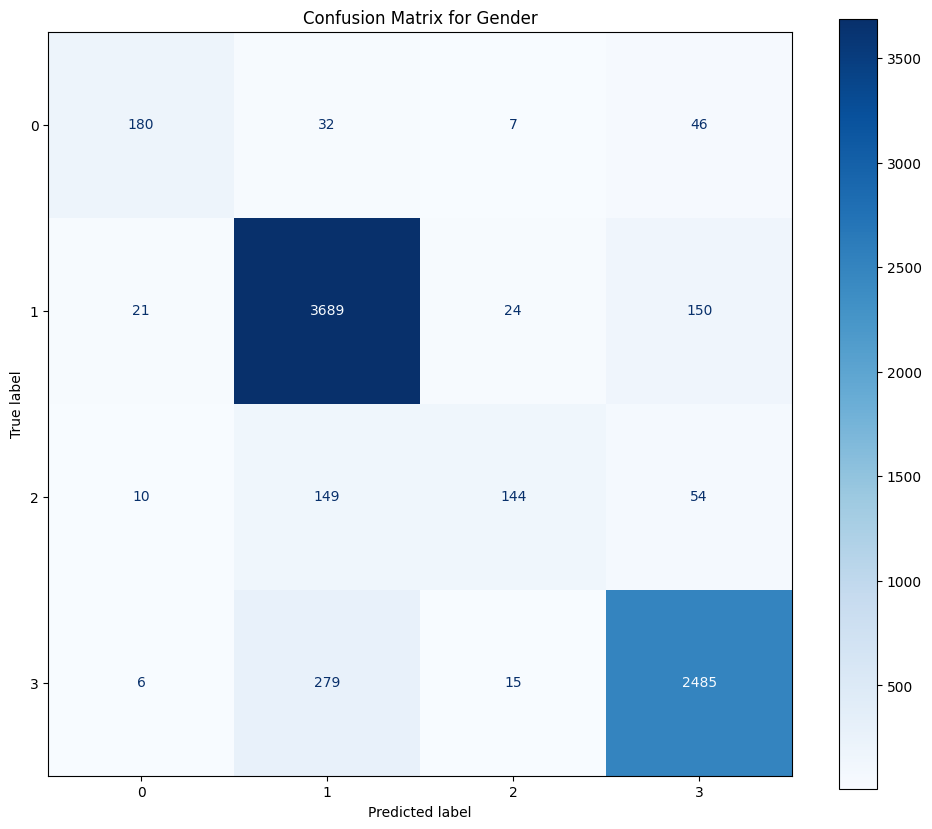

In [36]:
y_pred_gender_classes = np.argmax(y_pred_gender, axis=1)

cm = confusion_matrix(y_gender_val, y_pred_gender_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=article_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(12, 10)
plt.title('Confusion Matrix for Gender')
plt.show()

In [ ]:
#model.save('../backend/best_model.keras')